# Preprocessing

## Extract .mat Files from the Blackrock Raw Files

** Blackrock Data Files **

Blackrock raw data files come in their own peculiar format: http://support.blackrockmicro.com/KB/View/166838-file-specifications-packet-details-headers-etc

Luckily, we don't need too much knowledge of the inner workings of their data formats for two reasons:

1. All of the data that we care about lives in the .ns2 suffixed files in the raw > blackrock_original_data folder. These files house all of the actual electrode recordings. See the above link for descriptions of what the other files in this folder contain. The other files we may have potentially cared about is the .ns5 files because these contain the copy of the stimulation being sent to the TACS and thus could have potentially been used to extract stimulation events. However, upon inspection of this "stim" channel, I found out that the stimulation being recorded here does not actually fully match the stimulation being sent via the TACS. In particular, for the open trials, the 11 Hz sinusoidal signal was constantly being recorded in this channel, despite only being delivered in 10 second bursts because the TACS itself was being turned on and off to facilitate this (as opposed to turning the sinusoidal generator on and off). Because of this problem, I decided to just extract the stimulation events directly from the data files and ignore this channel (and consequently the .ns5 files) altogether.
2. Blackrock has a toolkit <a href="http://support.blackrockmicro.com/KB/View/166898-matlab-interfacing-and-analysis">NPMK</a> for extracting data from their file formats into MATLAB structs. I used this toolkit to extract the data as detailed below.

** Extracting the Data with NPMK **

1. First, I downloaded the NPMK toolkit folder via the instructions in the link above to the software folder: /autofs/space/sophia_001/users/szoro/software. 
2. Then I added the following lines to the file $HOME/startup.m so that matlab will find the NPMK functions upon opening:

        addpath /autofs/space/sophia_001/users/szoro/software/NPMK-4.4.0.0/NPMK/
        addpath '/autofs/space/sophia_001/users/szoro/software/NPMK-4.4.0.0/NPMK/Dependent Functions'
        
3. Type 'openNSx' at the command prompt. Then select the desired .ns2 file from the ./raw/blackrock_original_data and click open via the gui that pops up.
4. Save the resulting matlab struct with the following command where DATE gets replaced with the date in the filename, 'NS2' is the name of the extracted struct object, and '-v7.3' uses a version of save that supports larger file sizes (this assumes matlab's current directory is the project's base directory):

        save('./raw/matlab_extracted_data/DATE_ns2.mat', 'NS2', '-v7.3')

5. Repeat separately for each date's .ns2 file.

## Create Raw FIF files from Extracted .mat Files 

Unfortunately, Fieldtrip's functions for converting blackrock data into fieldtrip format are not fully functional. Because of this, I decided to just manually construct a raw object from the .mat file with MNE since I have a better understanding of the workings of MNE raw objects.

To do so I scrape out the bare minimum information needed to make an analyzable raw object:
  - The number of channels.
  - The names of the channels.
  - The sampling rate.
  - The actual data.
  - The digital to analog scaling factor.

I store the data as 'EEG' channels because MNE does not have explicit representations for intracranial recordings. Note that the data needs to be scaled appropriately to convert from digitized units to analog microvolt units. Additionally, I add an extra STIM channel with all 0's to be used to designate the stimulation events extracted in the next step.

In [1]:
from scipy.io import loadmat
import numpy as np
from mne import create_info
from mne.io import RawArray
import glob
import re
import h5py

fnames = glob.glob("./raw/matlab_extracted_data/*ns2.mat")

for f in fnames:
    
    date = re.search("\d{8}", f).group(0)
    print("Creating Raw FIF File for Date: %s" %(date))
    
    
    #################################
    # Pull Out Relevant Information #
    #################################
    
    # Had to use h5py because files were too large for normal matlab .mat files
    # and scipy.io.loadmat can't handle the resulting .mat format
    # WTF is this thing? Anyways indexing below was figured out through trial & error
    # Sorry for weirdness
    file_obj = h5py.File(f)
    struct = file_obj['NS2'] 
    data = np.array(struct['Data']).T
    srate = struct['MetaTags']['SamplingFreq'][0][0]
    dac_factor = float(file_obj[struct['ElectrodesInfo']['MaxAnalogValue'][0][0]][0][0])/file_obj[struct['ElectrodesInfo']['MaxDigiValue'][0][0]][0][0]
    ch_name_datasets = [file_obj[ref[0]] for ref in np.array(struct['ElectrodesInfo']['Label'])]
    ch_names = [u''.join(unichr(c) for c in l if c ) for l in ch_name_datasets]
    ch_names = [u'ref' if c == "elec1-84" else c for c in ch_names ] # Replace 'elec1-84' with ref since this was only done in some files
    
    ##########################
    # Create MNE Info Object #
    ##########################
    
    # Label electrodes as EEG type + add one stim
    ch_types = ['eeg'] * len(ch_names) + ['stim']
    
    # Add the STIM channel name
    ch_names.append("STIM")
    
    # Create the info object 
    info = create_info(ch_names, srate, ch_types)
    
    
    ############################
    # Create & Save Raw Object #
    ############################
    
    # Take the recorded data and add a row of 0's to represent the stim channel without events yet
    data = np.vstack((data, np.zeros(data.shape[-1])))
    
    # Convert from digitized units to microvolts
    data *= dac_factor

    raw = RawArray(data, info, verbose=False)
    raw.save("./raw/original_raw/%s_raw.fif" %(date), verbose=False, overwrite=True)

print("Done!")

Creating Raw FIF File for Date: 09012016
1000.0
Done!


## Manually Extract Stimulation Period Events 

Unfortunately, all of the timing of stimulation was done manually (meaning it isn't very precise) and none of the stimulation onsets & offsets were recorded in stim channels. Consequently, these stimulation events need to be extracted from the data (the copy of stimulation channel didn't work for extraction due to complications detailed in the Extract .mat files section). I tried playing around with some automatic extraction techniques (see Miscellaneous section), but overall found manual extraction to be more accurate.

Thus, I manually extracted events as follows:

1. Load the data in mne_browse_raw
2. Set the scales to be large (5e8) so the stimulation periods stand out, but fit in the frame. TURN OFF the average reference projection.
3. Go through and manually mark both the onset and offset of stimulation periods as user-defined events. I gave buffer after stim offset to account for the stimulation offset artifact (tried to pick point at which rebound stabilized). I used the view containing elec's 1-83, 82, 85 etc. since these are the electrodes neighboring the electrode being used to form the closed loop.
4. Save these defined events to a file: "./raw/manual_events/DATE_partX-eve.txt" Where the part refers to the numbering for FIF files that got split up into multiple files due to size. I also rename the raw files to fit this convention as well.
5. Repeat Steps 1-4 for each day of recording (some days were too big for a single FIF file so this step is actually repeat for each FIF file, the FIF files for a single day will later get concatenated together into a single epochs object).
6. Next, these events are loaded, morphed into square waves, and added to the STIM channel in the raw FIF files (code below). 
7. Finally, I visually sanity check the raw with the stim channel added.

** Notes on Raw Recordings/Stim Periods **

9/1/2016:  
9/2/2016: The first closed block seems to be surprisingly low amplitude during stim.  
9/6/2016: One of the brain trial runs had an extra trial (11 instead of 10) as documented in the lab notebook pictures. Rather, than painfully adjust the code to account for this outlier, I just didn't mark the stim events for the final trial so that there were only 10 instead of 11 trials.  
9/7/2016:  


In [ ]:
from mne.io import Raw
from mne import read_events

raw_fnames = sorted(glob.glob("./raw/original_raw/*_raw.fif"))
event_fnames = sorted(glob.glob("./raw/manual_events/*-eve.txt"))

for raw_f, eve_f in zip(raw_fnames, event_fnames):
    
    s = re.search(".*(\d{8}).*part(\d).*", raw_f)
    date, part = s.group(1), s.group(2)
    print("Adding Stim Events for Date: %s, Part: %s" %(date, part))
    
    #####################
    # Load Raw & Events #
    #####################
    
    raw = Raw(raw_f, verbose=False, preload=True, add_eeg_ref=False)
    events = read_events(eve_f)[1:, :]
    
    ##################################
    # Morph Events into Square Waves #
    ##################################
    
    new_events = []
    i = 0
    
    # Iterate through pairs of events representing marked stim onsets & offsets
    # Fill in all samples in between these two markers to create square waves lasting duration of stimulation
    while i < events.shape[0]:
        onset, offset = events[i, 0], events[i+1, 0]
        for j in range(onset, offset + 1):
            new_events.append([j, 0, 1])
        i += 2
        
    ############################
    # Add Events to Raw & Save #
    ############################
        
    raw.add_events(np.array(new_events), stim_channel="STIM")
    raw.save("./raw/manual_events/%s_part%s_with_manual_events_raw.fif" %(date, part), overwrite=True)

## Generate Stimulation Onset & Offset Locked Epochs

In [4]:
from mne.io import Raw, set_eeg_reference, set_bipolar_reference
from mne import find_events, Epochs, concatenate_raws, set_log_level
import numpy as np
import glob
import re
import pandas as pd
set_log_level('critical')

#######################################
# Load Raw Filenames & Condition Info #
#######################################

fnames = glob.glob("./raw/manual_events/*raw.fif")
condition_df = pd.read_csv("./lab_notebook/condition_info.csv", dtype={"Date":str, "Trial":int, "Block":int, "Condition":int})
dates = condition_df.Date.unique()

#####################
# Filter Parameters #
#####################

l_freq = .5
h_freq = 35.0 
l_trans_bandwidth = 'auto'
h_trans_bandwidth = 'auto'
filter_length = 'auto'
n_jobs = 3

#########################
# Trial Type Parameters #
#########################

for date in dates:
    
    print("Creating Epochs for Date: %s" %(date))
    
    ############################
    # Load  & Concatenate Raws #
    ############################

    date_raw_files = sorted([f for f in fnames if date in f])
    raws = [Raw(f, preload=True, verbose=False, add_eeg_ref=False) for f in date_raw_files]
    raw = concatenate_raws(raws)
    
    ################
    # Re-Reference #
    ################
    
    # Remove existing references
    set_eeg_reference(raw, [])
    for i in range(len(raw.info['projs'])):
        raw.del_proj(-1)
    
    ##############
    # Filter Raw #
    ##############

    raw.filter(l_freq = l_freq, h_freq = h_freq, filter_length=filter_length, n_jobs=n_jobs,
               l_trans_bandwidth=l_trans_bandwidth, h_trans_bandwidth=h_trans_bandwidth, phase='zero', fir_window='hamming')


    #######################
    # Extract Stim Events #
    #######################

    stim_on_events = find_events(raw, stim_channel="STIM", output='onset', verbose=False)
    stim_off_events = find_events(raw, stim_channel="STIM", output='offset', verbose=False)
    
    conditions = np.array(condition_df[condition_df.Date == date].Condition) 
    stim_on_events[:, -1] = conditions
    stim_off_events[:, -1] = conditions
    
    # Closed = Closed loop with current activity
    # Brain = Closed loop with previous day activity
    # Open = Constant 11 Hz stim
    if date == '09012016':
        event_id = dict(Open=0, Closed=1) # The first day didn't have the brain condition
    else:
        event_id = dict(Open=0, Closed=1, Brain=2)
        

    ###################
    # Generate Epochs #
    ###################
    
    # Generate & Save Epochs 
    
    on_epochs = Epochs(raw, events = stim_on_events, event_id = event_id, tmin = -15, tmax = 15, add_eeg_ref=False, preload=True)
    on_epochs.save("./epochs/%s_stim_onset-epo.fif" %(date))
    
    off_epochs = Epochs(raw, events = stim_off_events, event_id = event_id, tmin = -15, tmax = 15, add_eeg_ref=False, preload=True)
    off_epochs.save("./epochs/%s_stim_offset-epo.fif" %(date))
    

print("Done!")

Creating Epochs for Date: 09012016
Creating Epochs for Date: 09022016
Creating Epochs for Date: 09062016
Creating Epochs for Date: 09072016
Done!


# Time Frequency Power Calculation

## Generate Raw Time Frequency Power

Here we generate raw TFR power for -5 seconds pre-stimulation to 5 seconds post-stimulation. TFR from 5 to 30 Hz in linearly spaced steps using Morlet Wavelet Convolution.

In [26]:
from mne.time_frequency import tfr_morlet 
from mne import read_epochs, set_log_level
import numpy as np
import glob, re
import os
set_log_level('critical')


on_fnames = sorted(glob.glob("./epochs/*stim_onset-epo.fif"))
off_fnames = sorted(glob.glob("./epochs/*stim_offset-epo.fif"))

################################
# Define TFR Parameters #
################################

freqs = np.arange(5, 31, 1) # 5 -> 30 Hz linearly spaced
n_cycles = freqs # Match frequencies to give temporal resolution of 1 second at every frequency

for on_f, off_f in zip(on_fnames, off_fnames):

    date = re.search("(\d{8})", on_f).group(0)
    
    print("Computing Power for Date: %s" %(date))

    #####################
    # Load Epoched Data #
    #####################

    on_epochs = read_epochs(on_f, verbose=False)
    off_epochs = read_epochs(off_f, verbose=False)

    ##################################
    # Loop Through Stimulation Types #
    ##################################

    conditions = list(on_epochs.event_id.keys())

    for condition in conditions:
        print("Condition: %s" %(condition))

        #####################
        # Compute TFR Power #
        #####################

        # TFR representation using Morlet Wavelet Convolution
        on_power_epochs = tfr_morlet(on_epochs[condition], freqs=freqs, n_cycles=n_cycles, use_fft=True, 
                                    decim=10, return_itc=False, average=False, n_jobs=5)
        
        off_power_epochs = tfr_morlet(off_epochs[condition], freqs=freqs, n_cycles=n_cycles, use_fft=True, 
                                    decim=10, return_itc=False, average=False, n_jobs=5)


        # Include 5 seconds of activity on either side of stimulation
        # Take the first 5 seconds of stimulation from onset and
        # last 5 seconds of stimulation from offset to include stimulation period
        epoch_width = 5
        on_power_epochs.crop(-epoch_width, 4.99)
        off_power_epochs.crop(-5, epoch_width)

        # Get times array without buffer periods
        times = np.concatenate([on_power_epochs.times, off_power_epochs.times + 10])
        chs = on_power_epochs.ch_names

        # Stitch together onset & offset power
        trial_data = np.concatenate([on_power_epochs.data, off_power_epochs.data], 
                                    axis=-1)
        
        out_dir = './power/raw'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
        np.savez_compressed("%s/%s_%s_raw_power.npz" %(out_dir, condition, date), 
                            data=trial_data, chs=chs, times=times, freqs=freqs)
    
print("Done!")

Computing Power for Date: 09012016
Condition: Open


Process PoolWorker-5:
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/pickle.py", line 224, in dump
Traceback (most recent call last):
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/pool.py", line 117, in worker
    put((job, i, result))
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/externals/joblib/pool.py", line 384, in put
    wlock_acquire()
KeyboardInterrupt
Process PoolWorker-3:
Traceback (most recent call last):
  File "/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/multiprocessing/process.py", line 258, in _boo

KeyboardInterrupt: 

## Generate Trial Normalized TFR and Alpha & Beta Band Activity

Here we extract alpha and beta band activity normalized to a -5 to -1 pre-stimulation baseline period individually for each repeated trial of stimulation. We addtionally save out full trial normalized TFR power.

In [28]:
import glob, re
import numpy as np
import os

conditions = ["Open", "Closed", "Brain"]

baseline = (-5, -1)

##################################
# Loop Through Stimulation Types #
##################################

for condition in conditions:
    
    print("Computing Trial Normalized Band Power for Condition: %s" %(condition))
    
    fnames = sorted(glob.glob("./power/raw/*%s*_raw_power.npz" %(condition)))
    
    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']
    
    #######################################
    # Collect Date Data Within Conditions #
    #######################################
    
    raw_power = [np.load(f)['data'] for f in fnames]
    raw_power = np.concatenate(raw_power, axis=0)
    
    ###################
    # Normalize Power # 
    ###################
    
    # Power Normalizations are done according to Grandchamp & Delorme, 2011
    # Normalizations are done within condition, within electrode, within frequency
    
    # First Normalize Each Trial by Median of Entire Trial
    # Exclude the stimulation period and +- .5 seconds for edge artifact
    bl_mask = np.where(np.logical_or(times <= -.5, times >= 10.5))[0]
    trial_bl = np.median(raw_power[:, :, :, bl_mask], 
                         axis=-1)[:, :, :, np.newaxis]
    trial_norm_power = raw_power / trial_bl
    
    # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
    cond_power = np.median(trial_norm_power, axis=0)
    cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
    cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
    cond_norm_power = cond_power / cond_bl
    
    # Finally, Log Transform & Scale for Decibels 
    cond_norm_power = 10 * np.log10(cond_norm_power)
    
    # Save trial normalized tfr
    out_dir = './power/trial_normalized_tfr'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    np.savez_compressed("%s/%s_trial_normalized_tfr.npz" %(out_dir, condition), 
                        power=cond_norm_power, times=times, chs=chs, freqs=freqs)
    
    ######################
    # Extract Band Power # 
    ######################
    
    alpha = (8, 15)
    alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
    beta = (15, 30)
    beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))
    
    alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
    beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)
    
    ###################
    # Save Band Power # 
    ###################
    
    out_dir = './power/trial_normalized_band_power'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    np.savez_compressed("%s/%s_trial_normalized_band_power.npz" %(out_dir, condition), 
                        alpha_power=alpha_power, beta_power=beta_power, 
                        times=times, chs=chs)
    
print("Done!")

Computing Trial Normalized Band Power for Condition: Open
Computing Trial Normalized Band Power for Condition: Closed
Computing Trial Normalized Band Power for Condition: Brain
Done!


# Time Frequency Power Statistics [Not Stable or Re-Generated]

## Generate Trial Normalized Bootstrap Distribution

Here we do a resampling bootstrap on the trial normalized spotlight band waveforms to get estimates of standard error of mean waveforms.

### Pregenerate Bootstrap Resampled Indices for Each Condition 

Saved to file so that the cell that actually computes the bootstrap distribution can read these in from file and be reproducible across different runs.
Thus this cell should only be run once.

In [38]:
import numpy as np

np.random.seed(2129)

bootstrap_indices = {}

conditions = ["Open", "Closed", "Brain"]
sample_sizes = [100, 100, 80]

num_bootstrap_samples = 5000

for ss, c in zip(sample_sizes, conditions):
    bootstrap_indices[c] = np.random.choice(ss, size=(num_bootstrap_samples, 
                                                      ss), replace=True)

out_dir = './stats/bootstrap'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
np.savez_compressed("%s/bootstrap_indices.npz" % out_dir, 
                    Open=bootstrap_indices["Open"], 
                    Closed=bootstrap_indices["Closed"], 
                    Brain=bootstrap_indices["Brain"], 
                    num_samples=num_bootstrap_samples)

### Compute the Bootstrap Distribution

In [3]:
import numpy as np
import glob

###############################
# Define Important Parameters #
###############################

bootstrap_indices = np.load("./stats/bootstrap/bootstrap_indices.npz")
num_bootstrap_samples = bootstrap_indices['num_samples']

conditions = ["Open", "Closed", "Brain"]

print("Bootstrapping for Array 1")

for condition in conditions:
    
    print("Computing Bootstrap Distribution for Condition: %s" %(condition))
    
    ######################################
    # Collect Date Data Within Condition #
    ######################################
    
    fnames = sorted(glob.glob("./power/raw/*%s*_raw_power.npz" %(condition)))
    
    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']
    
    raw_power = [np.load(f)['data'] for f in fnames]
    raw_power = np.concatenate(raw_power, axis=0)
    
    # Subsample to array 1
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    raw_power = raw_power[:, arr1_ix, :, :].squeeze()
    
    # Subsample to only frequencies in alpha and beta band
    freq_ix = np.where(np.logical_and(freqs >= 8, freqs <= 30)) 
    freqs = np.arange(8, 31) 
    raw_power = raw_power[:, :, freq_ix, :].squeeze()
    
    # Select out pre and post stimulation
    # Collapse stimulation into 0 and make pre and post stimulation times
    # relative to this 0 (so no longer 10 + for post stimulation)
    times = tmp['times']
    pre_mask = np.logical_and(times >= -5, times <= -.5)
    post_mask = np.logical_and(times >= 10.5, times <= 15)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    times[times >= 10] -= 10
    raw_power = raw_power[:, :, :, time_mask].squeeze()
    
    ##################################
    # Loop Through Bootstrap Samples #
    ##################################
    
    bootstrap_cond_ix = bootstrap_indices[condition]
    
    alpha_bootstrap_samples = []
    beta_bootstrap_samples = []
    
    for i in range(num_bootstrap_samples):
        
        if (i+1) % 200 == 0:
            print("Bootstrap Sample # %d" %(i+1))
            
        bootstrap_ix = bootstrap_cond_ix[i, :]
        bootstrap_power = raw_power[bootstrap_ix, :, :, :]
        
        ###################
        # Normalize Power # 
        ###################

        # Power Normalizations are done according to Grandchamp & Delorme, 2011
        # Normalizations are done within condition, within electrode, within frequency

        # First Normalize Each Trial by Median of Entire Trial
        # I exclude -.5 -> .5 seconds around stimulation since these are contaminated
        # by stimulation edge artifact
        trial_bl = np.median(bootstrap_power, axis=-1)[:, :, :, np.newaxis]
        trial_norm_power = bootstrap_power / trial_bl

        # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
        baseline = (-5, -1)
        cond_power = np.median(trial_norm_power, axis=0)
        cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
        cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
        cond_norm_power = cond_power / cond_bl

        # Finally, Log Transform & Scale for Decibels 
        cond_norm_power = 10 * np.log10(cond_norm_power)

        ######################
        # Extract Band Power # 
        ######################

        alpha = (8, 15)
        alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
        beta = (15, 30)
        beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))

        alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
        beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)
    
        ###########################
        # Collapse Over Spotlight # 
        ###########################
        
        alpha_bootstrap_samples.append(np.mean(alpha_power, axis=0))
        beta_bootstrap_samples.append(np.mean(beta_power, axis=0))
    
    ##################################################
    # Save the Full Waveform Bootstrap Distributions # 
    ##################################################
    
    alpha_bootstrap_samples = np.vstack(alpha_bootstrap_samples)
    beta_bootstrap_samples = np.vstack(beta_bootstrap_samples)
    
    alpha_stderr = np.std(alpha_bootstrap_samples, axis=0)
    beta_stderr = np.std(beta_bootstrap_samples, axis=0)
    
    out_dir = './stats/bootstrap'
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    np.savez_compressed("%s/%s_bootstrap_distributions.npz" %(out_dir, 
                                                                 condition), 
                        alpha=alpha_bootstrap_samples, 
                        beta=beta_bootstrap_samples, 
                        alpha_stderr=alpha_stderr,
                        beta_stderr=beta_stderr, times=times)
    
print("Done!")

Boostrapping for Area: array1
Computing Bootstrap Distribution for Condition: Open
Bootstrap Sample # 200
Bootstrap Sample # 400
Bootstrap Sample # 600
Bootstrap Sample # 800
Bootstrap Sample # 1000
Bootstrap Sample # 1200
Bootstrap Sample # 1400
Bootstrap Sample # 1600
Bootstrap Sample # 1800
Bootstrap Sample # 2000
Bootstrap Sample # 2200
Bootstrap Sample # 2400
Bootstrap Sample # 2600
Bootstrap Sample # 2800
Bootstrap Sample # 3000
Bootstrap Sample # 3200
Bootstrap Sample # 3400
Bootstrap Sample # 3600
Bootstrap Sample # 3800
Bootstrap Sample # 4000
Bootstrap Sample # 4200
Bootstrap Sample # 4400
Bootstrap Sample # 4600
Bootstrap Sample # 4800
Bootstrap Sample # 5000
Computing Bootstrap Distribution for Condition: Closed
Bootstrap Sample # 200
Bootstrap Sample # 400
Bootstrap Sample # 600
Bootstrap Sample # 800
Bootstrap Sample # 1000
Bootstrap Sample # 1200
Bootstrap Sample # 1400
Bootstrap Sample # 1600
Bootstrap Sample # 1800
Bootstrap Sample # 2000
Bootstrap Sample # 2200
Bootst

### Perform Bootstrap Tests & FDR Corrections

In [4]:
import pylab as plt
import numpy as np
import seaborn as sns
from mne.stats import fdr_correction
sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

conditions = ["Open", "Closed", "Brain"]

toi = (10.5, 11)

print("Bootstrapping for Array 1")

(f, axs) = plt.subplots(2, 3, figsize=(20, 16))
plt.subplots_adjust(hspace=0.5, wspace=0.5)

cis = []
uncorrected_ps = []

for i, condition in enumerate(conditions):
    
    bootstrap_info = np.load("./stats/bootstrap/%s_bootstrap_distributions.npz" %(condition))
    alpha_dist = bootstrap_info['alpha']
    beta_dist = bootstrap_info['beta']
    
    actual_data = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(condition))
    alpha_data = actual_data['alpha_power']
    beta_data = actual_data['beta_power']
    chs = actual_data['chs']
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    
    alpha_data = alpha_data[arr_ix, :].squeeze().mean(axis=0)
    beta_data = beta_data[arr_ix, :].squeeze().mean(axis=0)
    
    times = bootstrap_info['times']
    toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))
    
    alpha_toi_dist = np.sort(alpha_dist[:, toi_mask].squeeze().mean(axis=-1))
    beta_toi_dist = np.sort(beta_dist[:, toi_mask].squeeze().mean(axis=-1))
    
    alpha_toi = alpha_data[toi_mask].squeeze().mean()
    beta_toi = beta_data[toi_mask].squeeze().mean()
    
    lower_ix = int(len(alpha_toi_dist) * .025)
    upper_ix = int(len(alpha_toi_dist) * .975)
    
    alpha_ci = [alpha_toi_dist[lower_ix], alpha_toi_dist[upper_ix]]
    beta_ci = [beta_toi_dist[lower_ix], beta_toi_dist[upper_ix]]
    alpha_center_dist = alpha_toi_dist - alpha_toi
    beta_center_dist = beta_toi_dist - beta_toi
    alpha_p = (np.sum(np.abs(alpha_center_dist) >= np.abs(alpha_toi)) + 1.) / (len(alpha_toi_dist) + 1.)
    beta_p = (np.sum(np.abs(beta_center_dist) >= np.abs(beta_toi)) + 1.) / (len(beta_toi_dist) + 1.)
    
    ax = axs[0, i]
    sns.distplot(alpha_toi_dist, ax=ax, color=COLORS[i])
    ax.axvline(alpha_ci[0], color='k')
    ax.axvline(alpha_ci[1], color='k')
    ax.axvline(alpha_toi, color=COLORS[i], linewidth=2)
    ax.set_title("%s Alpha Bootstrap Distribution \n Uncorrected p = %.3f" %(condition, alpha_p))
    
    ax = axs[1, i]
    sns.distplot(beta_toi_dist, ax=ax, color=COLORS[i])
    ax.axvline(beta_ci[0], color='k')
    ax.axvline(beta_ci[1], color='k')
    ax.axvline(beta_toi, color=COLORS[i], linewidth=2)
    ax.set_title("%s Beta Bootstrap Distribution \n Uncorrected p = %.3f" %(condition, beta_p))
    
    uncorrected_ps.append(alpha_p)
    uncorrected_ps.append(beta_p)
    cis.append(alpha_ci)
    cis.append(beta_ci)
    

print("Uncorrected P-Values:")
print("Open Alpha: %.3f" %uncorrected_ps[0])
print("Open Beta: %.3f" %uncorrected_ps[1])
print("Closed Alpha: %.3f" %uncorrected_ps[2])
print("Closed Beta: %.3f" %uncorrected_ps[3])
print("Brain Alpha: %.3f" %uncorrected_ps[4])
print("Brain Beta: %.3f" %uncorrected_ps[5])
print("")

###################
# FDR Corrections #
###################
    
reject, fdr_ps = fdr_correction(uncorrected_ps, alpha=.05)
print("FDR Corrected P-Values:")
print("Open Alpha: %.3f" %fdr_ps[0])
print("Open Beta: %.3f" %fdr_ps[1])
print("Closed Alpha: %.3f" %fdr_ps[2])
print("Closed Beta: %.3f" %fdr_ps[3])
print("Brain Alpha: %.3f" %fdr_ps[4])
print("Brain Beta: %.3f" %fdr_ps[5])

for i, ax in enumerate(axs.flatten(order='F')):
    ax.set_xlabel("Corrected p = %.3f" %(fdr_ps[i]))

sns.despine()
plt.savefig("./plots/stats_distributions/array1_condition_bootstrap_distributions.png")

#################
# Save P-Values #
#################
    
np.savez_compressed("./stats/bootstrap/bootstrap_p_values.npz", 
                    uncorrected_p_values = uncorrected_ps, 
                    fdr_corrected_p_values = fdr_ps, 
                    reject=reject, cis=cis)
print("Done!")

Bootstrapping for Area: array1
Uncorrected P-Values:
Open Alpha: 0.066
Open Beta: 0.331
Closed Alpha: 0.379
Closed Beta: 0.973
Brain Alpha: 0.015
Brain Beta: 0.074

FDR Corrected P-Values:
Open Alpha: 0.149
Open Beta: 0.455
Closed Alpha: 0.455
Closed Beta: 0.973
Brain Alpha: 0.091
Brain Beta: 0.149
Done!


## Permutation Tests for Condition Differences in Post-Stim Power 

Permutations are done with trials across conditions. The permutations are used to build a distribution
for the difference in the mean spotlight power band activity from 0.5 - 1.5 seconds post-stim.

### Pre-Generate Permutation Indices

In [5]:
import numpy as np

np.random.seed(2129)

permutation_indices = {}

tests = ["Open-Closed", "Open-Brain", "Brain-Closed"]

num_permutations = 5000
sample_size = [100, 80, 80]

for ss, t in zip(sample_size, tests):
    permutations = np.zeros((num_permutations, ss * 2), dtype=np.int32)
    ix = np.arange(ss * 2)
    for i in range(num_permutations):
        np.random.shuffle(ix)
        permutations[i, :] = ix 
    permutation_indices[t] = permutations
    
out_dir = './stats/condition_permutations'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
np.savez_compressed("%s/stats/condition_permutations/permutation_indices.npz" % out_dir, 
                    Open_Closed=permutation_indices["Open-Closed"], 
                    Open_Brain=permutation_indices["Open-Brain"], 
                    Brain_Closed=permutation_indices["Brain-Closed"], 
                    num_permutations=num_permutations)

### Generate Random Indices to Equalize Trial Count Across Conditions

Since the brain condition was not collected on the first day, it only has 80 trials compared to 100 trials in the open
and closed condition. Here we randomly subsample 80 trials indices from the open and closed conditions to equalize trial count
for comparisons between conditions.

In [6]:
import numpy as np

np.random.seed(2129)

trial_indices = {}


conditions = ["Open", "Closed"]
num_permutations = 5000
original_sample_sizes = [100, 100]
desired_sample_sizes = [80, 80]

for oss, dss, c in zip(original_sample_sizes, desired_sample_sizes, conditions):
    trial_indices[c] = np.zeros((num_permutations, dss), dtype=np.int32)
    for i in range(num_permutations):
        trial_indices[c][i, :] = np.random.choice(oss, size=dss, replace=False)

np.savez_compressed("./stats/condition_permutations/trial_count_indices.npz", 
                    Open=trial_indices["Open"], Closed=trial_indices["Closed"])

### Compute the Permutation Distribution

In [9]:
import numpy as np
import glob
import pylab as plt
import seaborn as sns

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

###############################
# Define Important Parameters #
###############################

permutation_indices = np.load("./stats/condition_permutations/permutation_indices.npz")
num_permutations = permutation_indices['num_permutations']

comparisons = [["Open", "Closed"], ["Open", "Brain"], ["Brain", "Closed"]]

toi = (10.5, 11.0)

for comp in comparisons:
    conditions = comp

    print("Computing Permutation Distribution for Condition Comparison: %s-%s" %(conditions[0], conditions[1]))

    all_conditions_raw_power = {}

    for condition in conditions:

        ######################################
        # Collect Date Data Within Condition #
        ######################################

        fnames = sorted(glob.glob("./power/*%s*_raw_power.npz" %(condition)))

        tmp = np.load(fnames[0])
        times = tmp['times']
        chs = tmp['chs']
        freqs = tmp['freqs']

        raw_power = [np.load(f)['data'] for f in fnames]
        raw_power = np.concatenate(raw_power, axis=0)
        
        spot_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']

        # Subsample to areas of interest for performance
        freq_ix = np.where(np.logical_and(freqs >= 8, freqs <= 30)) 
        freqs = np.arange(8, 31) 
        raw_power = raw_power[:, spot_ix, :, :].squeeze()
        raw_power = raw_power[:, :, freq_ix, :].squeeze()

        all_conditions_raw_power[condition] = raw_power


    #############################
    # Loop Through Permutations #
    #############################

    permutation_info = {}
    permutation_info['alpha_perm_dist'] = []
    permutation_info['beta_perm_dist'] = []

    permutation_cond_ix = permutation_indices["%s_%s"%(conditions[0], conditions[1])]
    trial_indices = np.load("./stats/condition_permutations/trial_count_indices.npz")

    for i in range(num_permutations + 1):

        if (i) % 200 == 0:
            print("Permutation # %d" %(i))

        ###############################################
        # Sub-select Trials to Match Condition Counts #
        ###############################################

        raw_power = []
        cond_shapes = []
        for c in conditions:
            power = all_conditions_raw_power[c]

            if i > 0 and "Brain" in conditions and c != "Brain":
                trial_ix = trial_indices[c][i-1, :]
                power = power[trial_ix, :, :, :].squeeze()

            cond_shapes.append(power.shape[0])
            raw_power.append(power)

        ######################################
        # Combine & Permute Condition Labels #
        ######################################

        raw_power = np.vstack(raw_power)
        del power

        # First Iteration Returns Us the Actual Statistic Value
        # Other Iterations Are Permutations
        if i == 0:
            perm_power = raw_power
        else:
            perm_ix = permutation_cond_ix[i-1, :]
            perm_power = raw_power[perm_ix, :, :, :].squeeze()

        alpha_tois = []
        beta_tois = []

        for j, cond in enumerate(conditions):

            if j == 0:
                cond_raw_power = perm_power[0:cond_shapes[0], :, :, :]
            else:
                cond_raw_power = perm_power[cond_shapes[0]:, :, :, :]

            ###################
            # Normalize Power # 
            ###################

            # Power Normalizations are done according to Grandchamp & Delorme, 2011
            # Normalizations are done within condition, within electrode, within frequency

            # First Normalize Each Trial by Median of Entire Trial
            # I exclude -.5 -> .5 seconds around stimulation since these are contaminated
            # by stimulation edge artifact
            trial_bl = np.median(cond_raw_power, axis=-1)[:, :, :, np.newaxis]
            trial_norm_power = cond_raw_power / trial_bl

            # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
            baseline = (-5, -1)
            cond_power = np.median(trial_norm_power, axis=0)
            cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
            cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
            cond_norm_power = cond_power / cond_bl

            # Finally, Log Transform & Scale for Decibels 
            cond_norm_power = 10 * np.log10(cond_norm_power)

            ######################
            # Extract Band Power # 
            ######################

            alpha = (8, 15)
            alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
            beta = (15, 30)
            beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))

            alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
            beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)

            ###########################
            # Collapse Over Spotlight # 
            ###########################

            alpha_power = np.mean(alpha_power, axis=0).squeeze()
            beta_power = np.mean(beta_power, axis=0).squeeze()

            #####################
            # Collapse Over TOI # 
            #####################

            toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))

            alpha_tois.append(alpha_power[toi_mask].mean())
            beta_tois.append(beta_power[toi_mask].mean())

        ################################
        # Take Difference of TOI Means # 
        ################################

        if i == 0:
            permutation_info['alpha_diff'] = alpha_tois[0] - alpha_tois[1]
            permutation_info['beta_diff'] = beta_tois[0] - beta_tois[1]
        else:
            permutation_info['alpha_perm_dist'].append(alpha_tois[0] - alpha_tois[1])
            permutation_info['beta_perm_dist'].append(beta_tois[0] - beta_tois[1])

    ####################
    # Compute P-Values # 
    ####################

    permutation_info['alpha_p_value'] = (np.sum(np.abs(np.array(permutation_info['alpha_perm_dist'])) > np.abs(permutation_info['alpha_diff'])) + 1.) / (num_permutations + 1.)
    permutation_info['beta_p_value'] = (np.sum(np.abs(np.array(permutation_info['beta_perm_dist'])) > np.abs(permutation_info['beta_diff'])) + 1.) / (num_permutations + 1.)

#     #################################
#     # Plot Permutation Distribution #
#     #################################

#     f, axs = plt.subplots(1, 2, figsize=(18, 10))

#     sns.distplot(permutation_info['alpha_perm_dist'], ax=axs[0], color=COLORS[1])
#     axs[0].axvline(permutation_info['alpha_diff'], color=COLORS[1])
#     axs[0].set_title("Alpha Uncorrected p-value: %.2f"%permutation_info['alpha_p_value'])

#     sns.distplot(permutation_info['beta_perm_dist'], ax=axs[1], color=COLORS[1])
#     axs[1].axvline(permutation_info['beta_diff'], color=COLORS[1])
#     axs[1].set_title("Beta Uncorrected p-value: %.2f" %permutation_info['beta_p_value'])

#     plt.suptitle("%s-%s toi=(%.2f, %.2f)" %(conditions[0], conditions[1], toi[0], toi[1]))
#     sns.despine()
#     plt.savefig("./plots/%s-%s_toi=(%.2f,%.2f)_%s_permutation_dist.png"%(conditions[0], conditions[1], 
#                                                                          toi[0], toi[1], spotlight))

    ####################################
    # Save the Permutation Information # 
    ####################################

    np.savez_compressed("./stats/condition_permutations/%s-%s_toi=(%.2f,%.2f)_%s_permutation_info.npz" %(conditions[0], conditions[1], toi[0], toi[1], spotlight), alpha_dist = permutation_info['alpha_perm_dist'],
                        beta_dist = permutation_info['beta_perm_dist'], alpha_diff = permutation_info['alpha_diff'], beta_diff=permutation_info['beta_diff'],
                        num_permutations=num_permutations, alpha_p_value = permutation_info['alpha_p_value'], beta_p_value = permutation_info['beta_p_value'])

print("Done!")

Computing Permutation Distribution for Condition Comparison: Open-Closed
Permutation # 0
Permutation # 200
Permutation # 400
Permutation # 600
Permutation # 800
Permutation # 1000
Permutation # 1200
Permutation # 1400
Permutation # 1600
Permutation # 1800
Permutation # 2000
Permutation # 2200
Permutation # 2400
Permutation # 2600
Permutation # 2800
Permutation # 3000
Permutation # 3200
Permutation # 3400
Permutation # 3600
Permutation # 3800
Permutation # 4000
Permutation # 4200
Permutation # 4400
Permutation # 4600
Permutation # 4800
Permutation # 5000
Computing Permutation Distribution for Condition Comparison: Open-Brain
Permutation # 0
Permutation # 200
Permutation # 400
Permutation # 600
Permutation # 800
Permutation # 1000
Permutation # 1200
Permutation # 1400
Permutation # 1600
Permutation # 1800
Permutation # 2000
Permutation # 2200
Permutation # 2400
Permutation # 2600
Permutation # 2800
Permutation # 3000
Permutation # 3200
Permutation # 3400
Permutation # 3600
Permutation # 

### Permutation Tests & FDR Corrections 

In [10]:
from mne.stats import fdr_correction
import numpy as np

###################################
# Accumulate Permutation P-Values #
###################################

comparisons = ["Open-Closed", "Open-Brain", "Brain-Closed"]
toi=(0.5, 1.0)
spotlight="array1"
uncorrected_ps = []

(f, axs) = plt.subplots(2, 3, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

print("Computing Permutation Statistics for %s" %(spotlight))

for i, comp in enumerate(comparisons):
    perm_info = np.load("./stats/condition_permutations/%s_toi=(%.2f,%.2f)_%s_permutation_info.npz" %(comp, toi[0], toi[1], spotlight))
    
    
    #################################
    # Plot Permutation Distribution #
    #################################
    
    ax = axs[0, i]
    sns.distplot(perm_info['alpha_dist'], ax=ax)
    ax.axvline(perm_info['alpha_diff'], color=COLORS[1])
    ax.set_title("%s Alpha Power \n Uncorrected p = %.3f" %(comp, perm_info['alpha_p_value']))
    
    ax = axs[1, i]
    sns.distplot(perm_info['beta_dist'], ax=ax)
    ax.axvline(perm_info['beta_diff'], color=COLORS[1])
    ax.set_title("%s Beta Power \n Uncorrected p = %.3f" %(comp, perm_info['beta_p_value']))

    uncorrected_ps.append(perm_info['alpha_p_value'])
    uncorrected_ps.append(perm_info['beta_p_value'])

print("Uncorrected P-Values:")
print("Open-Closed Alpha: %.3f" %uncorrected_ps[0])
print("Open-Closed Beta: %.3f" %uncorrected_ps[1])
print("Open-Brain Alpha: %.3f" %uncorrected_ps[2])
print("Open-Brain Beta: %.3f" %uncorrected_ps[3])
print("Brain-Closed Alpha: %.3f" %uncorrected_ps[4])
print("Brain-Closed Beta: %.3f" %uncorrected_ps[5])
print("")

###################
# FDR Corrections #
###################
    
reject, fdr_ps = fdr_correction(uncorrected_ps, alpha=.05)
print("FDR Corrected P-Values:")
print("Open-Closed Alpha: %.3f" %fdr_ps[0])
print("Open-Closed Beta: %.3f" %fdr_ps[1])
print("Open-Brain Alpha: %.3f" %fdr_ps[2])
print("Open-Brain Beta: %.3f" %fdr_ps[3])
print("Brain-Closed Alpha: %.3f" %fdr_ps[4])
print("Brain-Closed Beta: %.3f" %fdr_ps[5])

for i, ax in enumerate(axs.flatten(order='F')):
    ax.set_xlabel("Corrected p = %.3f" %(fdr_ps[i]))

sns.despine()
plt.savefig("./plots/toi=(%.2f,%.2f)_%s_condition_permutation_dist.png"%(toi[0], toi[1], spotlight)) 

#################
# Save P-Values #
#################
    
np.savez_compressed("./stats/condition_permutations/toi=(%.2f,%.2f)_%s_condition_comparison_p_values.npz"%(toi[0], toi[1], spotlight), uncorrected_p_values = uncorrected_ps, fdr_corrected_p_values = fdr_ps, reject=reject)
print("Done!")

Computing Permutation Statistics for array1
Uncorrected P-Values:
Open-Closed Alpha: 0.041
Open-Closed Beta: 0.406
Open-Brain Alpha: 0.667
Open-Brain Beta: 0.617
Brain-Closed Alpha: 0.016
Brain-Closed Beta: 0.175

FDR Corrected P-Values:
Open-Closed Alpha: 0.122
Open-Closed Beta: 0.608
Open-Brain Alpha: 0.667
Open-Brain Beta: 0.667
Brain-Closed Alpha: 0.096
Brain-Closed Beta: 0.350
Done!


## Permutation Tests for Array Differences in Post-Stim Power

### Compute the Permutation Distribution 

In [13]:
import numpy as np
import glob
import pylab as plt
import seaborn as sns
import scipy.stats

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

conditions = ["Open", "Closed", "Brain"]

for condition in conditions:
    
    ######################################
    # Collect Date Data Within Condition #
    ######################################

    fnames = sorted(glob.glob("./power/*%s*_raw_power.npz" %(condition)))

    tmp = np.load(fnames[0])
    times = tmp['times']
    chs = tmp['chs']
    freqs = tmp['freqs']

    raw_power = [np.load(f)['data'] for f in fnames]
    cond_raw_power = np.concatenate(raw_power, axis=0)

    ###################
    # Normalize Power # 
    ###################

    # Power Normalizations are done according to Grandchamp & Delorme, 2011
    # Normalizations are done within condition, within electrode, within frequency

    # First Normalize Each Trial by Median of Entire Trial
    # I exclude -.5 -> .5 seconds around stimulation since these are contaminated
    # by stimulation edge artifact
    trial_bl = np.median(cond_raw_power, axis=-1)[:, :, :, np.newaxis]
    trial_norm_power = cond_raw_power / trial_bl

    # Then Median & Normalize Within Condition by Median of Pre-Stim Baseline Period
    baseline = (-5, -1)
    cond_power = np.median(trial_norm_power, axis=0)
    cond_bl_mask = np.where(np.logical_and(times >= baseline[0], times <= baseline[1]))
    cond_bl = np.median(cond_power[:, :, cond_bl_mask].squeeze(), axis=-1)[:, :, np.newaxis]
    cond_norm_power = cond_power / cond_bl

    # Finally, Log Transform & Scale for Decibels 
    cond_norm_power = 10 * np.log10(cond_norm_power)

    ######################
    # Extract Band Power # 
    ######################

    alpha = (8, 15)
    alpha_mask = np.where(np.logical_and(freqs >= alpha[0], freqs <= alpha[1]))
    beta = (15, 30)
    beta_mask = np.where(np.logical_and(freqs >= beta[0], freqs <= beta[1]))

    alpha_power = np.mean(cond_norm_power[:, alpha_mask, :].squeeze(), axis=1)
    beta_power = np.mean(cond_norm_power[:, beta_mask, :].squeeze(), axis=1)
    
    #############################
    # Loop Through Permutations #
    #############################

    permutation_info = {}
    permutation_info['alpha_perm_dist'] = []
    permutation_info['beta_perm_dist'] = []

    num_permutations = 5000
    np.random.seed(2129)

    print("Computing Permutation Distribution for Condition: %s" %(condition))

    for i in range(num_permutations + 1):

        ###########################
        # Shuffle Channel Indices #
        ###########################

        if i > 0:
            np.random.shuffle(chs)
        arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
        arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]


        #####################
        # Collapse Over TOI # 
        #####################

        toi = (0.5, 1.0)
        toi_mask = np.where(np.logical_and(times >= toi[0], times <= toi[1]))

        alpha_toi = alpha_power[:, toi_mask].mean(axis=-1)
        beta_toi = beta_power[:, toi_mask].mean(axis=-1)
        
        ####################################
        # Compute & Accumulate T-Statistic # 
        ####################################
        
        alpha_t, _ = scipy.stats.ttest_ind(alpha_toi[arr1_ix], alpha_toi[arr2_ix])
        beta_t, _ = scipy.stats.ttest_ind(beta_toi[arr1_ix], beta_toi[arr2_ix])

        if i == 0:
            permutation_info['alpha_diff'] = alpha_t 
            permutation_info['beta_diff'] = beta_t 
        else:
            permutation_info['alpha_perm_dist'].append(alpha_t)
            permutation_info['beta_perm_dist'].append(beta_t)

    ####################
    # Compute P-Values # 
    ####################

    permutation_info['alpha_p_value'] = (np.sum(np.abs(np.array(permutation_info['alpha_perm_dist'])) > np.abs(permutation_info['alpha_diff'])) + 1.) / (num_permutations + 1.)
    permutation_info['beta_p_value'] = (np.sum(np.abs(np.array(permutation_info['beta_perm_dist'])) > np.abs(permutation_info['beta_diff'])) + 1.) / (num_permutations + 1.)

#     #################################
#     # Plot Permutation Distribution #
#     #################################

#     f, axs = plt.subplots(1, 2, figsize=(18, 10))

#     sns.distplot(permutation_info['alpha_perm_dist'], ax=axs[0], color=COLORS[1])
#     axs[0].axvline(permutation_info['alpha_diff'], color=COLORS[1])
#     axs[0].set_title("Alpha Uncorrected p-value: %.2f"%permutation_info['alpha_p_value'])

#     sns.distplot(permutation_info['beta_perm_dist'], ax=axs[1], color=COLORS[1])
#     axs[1].axvline(permutation_info['beta_diff'], color=COLORS[1])
#     axs[1].set_title("Beta Uncorrected p-value: %.2f" %permutation_info['beta_p_value'])

#     plt.suptitle("%s Array1 vs. Array2 toi=(%.2f, %.2f)" %(condition, toi[0], toi[1]))
#     sns.despine()
#     plt.savefig("./plots/%s_array_toi=(%.2f,%.2f)_permutation_dist.png"%(condition, toi[0], toi[1]))

    ####################################
    # Save the Permutation Information # 
    ####################################

    np.savez_compressed("./stats/array_permutations/%s_toi=(%.2f,%.2f)_array_permutation_info.npz" %(condition, toi[0], toi[1]), alpha_dist = permutation_info['alpha_perm_dist'],
                        beta_dist = permutation_info['beta_perm_dist'], alpha_diff = permutation_info['alpha_diff'], beta_diff=permutation_info['beta_diff'],
                        num_permutations=num_permutations, alpha_p_value = permutation_info['alpha_p_value'], beta_p_value = permutation_info['beta_p_value'])

print("Done!")

Computing Permutation Distribution for Condition: Open
Computing Permutation Distribution for Condition: Closed
Computing Permutation Distribution for Condition: Brain
Done!


### Permutation Tests & FDR Corrections 

In [14]:
from mne.stats import fdr_correction
import numpy as np

###################################
# Accumulate Permutation P-Values #
###################################

conditions = ["Open", "Closed", "Brain"]
toi=(0.5, 1.0)
uncorrected_ps = []

(f, axs) = plt.subplots(2, 3, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.2)

print("Computing Permutation Statistics for TOI=(%.2f, %.2f)" %(toi[0], toi[1]))

for i, condition in enumerate(conditions):
    perm_info = np.load("./stats/array_permutations/%s_toi=(%.2f,%.2f)_array_permutation_info.npz" %(condition, toi[0], toi[1]))
    uncorrected_ps.append(perm_info['alpha_p_value'])
    uncorrected_ps.append(perm_info['beta_p_value'])
    
    #################################
    # Plot Permutation Distribution #
    #################################
    
    ax = axs[0, i]
    sns.distplot(perm_info['alpha_dist'], ax=ax, color=COLORS[i])
    ax.axvline(perm_info['alpha_diff'], color=COLORS[i])
    ax.set_title("%s Alpha Power \n Uncorrected p = %.3f" %(condition, perm_info['alpha_p_value']))
    
    ax = axs[1, i]
    sns.distplot(perm_info['beta_dist'], ax=ax, color=COLORS[i])
    ax.axvline(perm_info['beta_diff'], color=COLORS[i])
    ax.set_title("%s Beta Power \n Uncorrected p = %.3f" %(condition, perm_info['beta_p_value']))

print("Uncorrected P-Values:")
print("Open Alpha: %.3f" %uncorrected_ps[0])
print("Open Beta: %.3f" %uncorrected_ps[1])
print("Closed Alpha: %.3f" %uncorrected_ps[2])
print("Closed Beta: %.3f" %uncorrected_ps[3])
print("Brain Alpha: %.3f" %uncorrected_ps[4])
print("Brain Beta: %.3f" %uncorrected_ps[5])
print("")

###################
# FDR Corrections #
###################
    
reject, fdr_ps = fdr_correction(uncorrected_ps, alpha=.05)
print("FDR Corrected P-Values:")
print("Open Alpha: %.3f" %fdr_ps[0])
print("Open Beta: %.3f" %fdr_ps[1])
print("Closed Alpha: %.3f" %fdr_ps[2])
print("Closed Beta: %.3f" %fdr_ps[3])
print("Brain Alpha: %.3f" %fdr_ps[4])
print("Brain Beta: %.3f" %fdr_ps[5])

for i, ax in enumerate(axs.flatten(order='F')):
    ax.set_xlabel("Corrected p = %.3f" %(fdr_ps[i]))

sns.despine()
plt.savefig("./plots/toi=(%.2f,%.2f)_array_permutation_dist.png"%(toi[0], toi[1])) 

#################
# Save P-Values #
#################
    
np.savez_compressed("./stats/array_permutations/toi=(%.2f,%.2f)_array_comparison_p_values.npz"%(toi[0], toi[1]), uncorrected_p_values = uncorrected_ps, fdr_corrected_p_values = fdr_ps, reject=reject)
print("Done!")

Computing Permutation Statistics for TOI=(0.50, 1.00)
Uncorrected P-Values:
Open Alpha: 0.000
Open Beta: 0.000
Closed Alpha: 0.012
Closed Beta: 0.000
Brain Alpha: 0.000
Brain Beta: 0.001

FDR Corrected P-Values:
Open Alpha: 0.000
Open Beta: 0.000
Closed Alpha: 0.012
Closed Beta: 0.000
Brain Alpha: 0.000
Brain Beta: 0.002
Done!


# Time Frequency Power Visualization

## Trial Normalized Band Power Across Entire Arrays

### Preprocess Trial Normalized Band Power Into Arrays

This cell must be run prior to the ensuing cell so that the variable trial_power_struct is in memory.

In [58]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

% matplotlib inline

####################################
# Load Power & Reshape Into Arrays #
####################################

conditions = ["Open", "Closed", "Brain"]

trial_power_struct= {}

for c in conditions:
    print(c)
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    times = tmp['times']
    trial_power_struct['times'] = times
    chs = tmp['chs']
    
    for band in ["alpha", "beta"]:
        print(band)
        
        data = tmp["%s_power"%(band)]
        num_samples = data.shape[-1]
        
        # Add in zeros as placeholder for closed loop pair in array 1
        replace_ix = np.where(chs == 'elec1-83')
        data[replace_ix, :] = np.zeros(num_samples)
        replace_ix = np.where(chs == 'ref')
        data[replace_ix, :] = np.zeros(num_samples)
        chs[replace_ix] = 'elec1-84'
        
        ch_nums = [int(ch[ch.index('-') + 1:]) + int(ch[ch.index('-')-1]) * 1000 for ch in chs]
        sort_ix = np.argsort(ch_nums) 
        chs_sorted = chs[sort_ix]
        data = data[sort_ix, :]
        
        # Select out data for each array
        arr1_index = [ix for ix in np.arange(len(chs_sorted)) if 'elec1' in chs_sorted[ix]]
        arr2_index = [ix for ix in np.arange(len(chs_sorted)) if 'elec2' in chs_sorted[ix]]
        arr1_power = data[arr1_index, :]
        arr2_power = data[arr2_index, :]
        
        # Reshape to shape of electrode array
        arr1_power = np.reshape(arr1_power, (8, 8, num_samples))
        arr2_power = np.reshape(arr2_power, (8, 8, num_samples))
        
        # Reorient to Equal Actual Array Orientation
        for i in range(num_samples):
            arr1_power[:, :, i] = arr1_power[:, :, i].squeeze().T[::-1, :][:, ::-1]
            arr2_power[:, :, i] = arr2_power[:, :, i].squeeze().T[::-1, :][:, ::-1]
        
        # Store in persistent structure
        trial_power_struct['%s_%s_array1_power'%(c, band)] = arr1_power
        trial_power_struct['%s_%s_array2_power'%(c, band)] = arr2_power
        
print("Done!")    

Open
alpha
beta
Closed
alpha
beta
Brain
alpha
beta
Done!


### Interactively Display Trial Normalized Array Band Power 

In [59]:
def plot_array_band_activity(time_ix, band):
    
    conditions = ["Open", "Closed", "Brain"]
    
    times = trial_power_struct['times']
    
    f, axs = plt.subplots(2, 3, figsize=(16, 14))
    plt.subplots_adjust(hspace=-.2, wspace=0.1)
    f.suptitle("Trial Normalized Power, T = %.3f s" %(times[time_ix]), fontsize=25, y=.90)
    vmin, vmax = -1, 1 
    
    for i, c in enumerate(conditions):
        
        ax = axs[0, i]
        data = trial_power_struct["%s_%s_array1_power"%(c, band)][:, :, time_ix].squeeze()
        mask = np.zeros((8, 8))
        mask[data == 0] = 1
        mask[data != 0] = np.nan
        ax.imshow(data, interpolation='nearest', cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.imshow(mask, interpolation='nearest', vmin=.8, vmax=1)
        ax.set_title("Array 1 %s Alpha Power" %(c.capitalize()))
        ax.set_xticks(())
        ax.set_yticks(())
        
        ax = axs[1, i]
        data = trial_power_struct["%s_%s_array2_power"%(c, band)][:, :, time_ix].squeeze(),
        im = ax.imshow(data[0], interpolation='nearest', cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_title("Array 2 %s Alpha Power" %(c.capitalize()))
        ax.set_xticks(())
        ax.set_yticks(())
    
    f.subplots_adjust(right=.88)
    cbar_ax = f.add_axes([0.9, 0.25, 0.05, 0.5])
    f.colorbar(im, cax=cbar_ax)
    
    plt.show()

In [60]:
from ipywidgets import interact
interact(plot_array_band_activity, time_ix = (0, num_samples, 10), band = ["alpha", "beta"])

<function __main__.plot_array_band_activity>

## [Manuscript Figure] Trial Normalized Pre- and Post-Stimulation TFR Power 

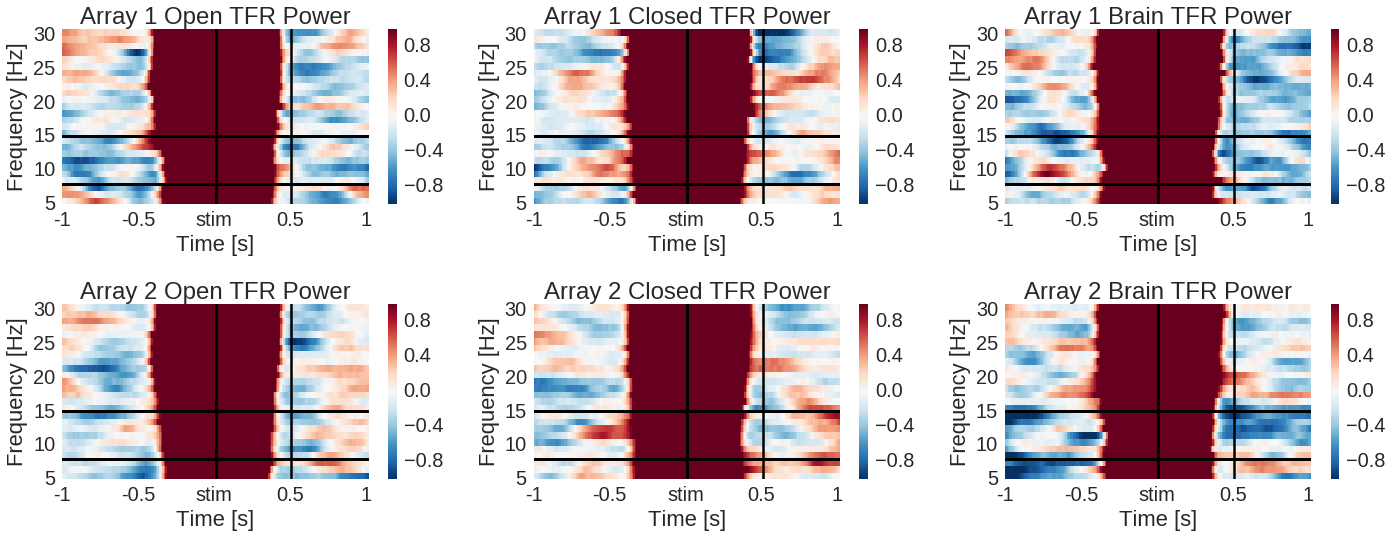

In [65]:
import numpy as np
import os, glob, re
import pylab as plt
import seaborn as sns

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')
        
f, axs = plt.subplots(2, 3, figsize=(20, 8))

for i, condition in enumerate(['Open', 'Closed', 'Brain']):
    
    power = np.load('./power/trial_normalized_tfr/%s_trial_normalized_tfr.npz' % condition)
    
    data = power['power']
    freqs = power['freqs']
    times = power['times']
    chs = power['chs']
    
    # Crop out period of interest
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    pre_mask = np.logical_and(times >= -1, times <= 0)
    post_mask = np.logical_and(times >= 10, times <= 11)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    toi_mask = np.where(np.logical_and(times >= 10.5, times <= 11))[0]
    alpha_mask = np.where(np.logical_and(freqs >= 8, freqs <= 15))[0]
    
    time_steps = np.arange(0, len(times) + 1, 50)
    freq_steps = np.arange(0, len(freqs), 5)
    
    for j, ix in enumerate([arr1_ix, arr2_ix]):
        
        arr_data = data[ix, :, :].mean(axis=0)
        arr_data = arr_data[:, time_mask]
        ax = axs[j, i]
        sns.heatmap(arr_data, ax=ax, vmin=-1, vmax=1)
        ad = arr_data[alpha_mask].mean(axis=0)
    
        ax.set_xticks(time_steps)
        ax.set_xticklabels([-1, -.5, 'stim', .5, 1], rotation=0)
        ax.set_yticks(freq_steps)
        ax.set_yticklabels(freqs[freq_steps])
        
        ax.axvline(len(times)/2, color='k', linewidth=3)
        ax.axvline(np.where(times == 10.5)[0], color='k')
        ax.axhline(3, color='k', linewidth=3)
        ax.axhline(10, color='k', linewidth=3)
        
        if j == 0:
            ax.set_title('Array 1 %s TFR Power' % condition)
        else:
            ax.set_title('Array 2 %s TFR Power' % condition)
        
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [Hz]')
            
plt.tight_layout()
plt.savefig('./plots/manuscript_figures/pre-post-tfr.png')
plt.show()

## [Manuscript Figure] Early and Late Stimulation Power Spectra

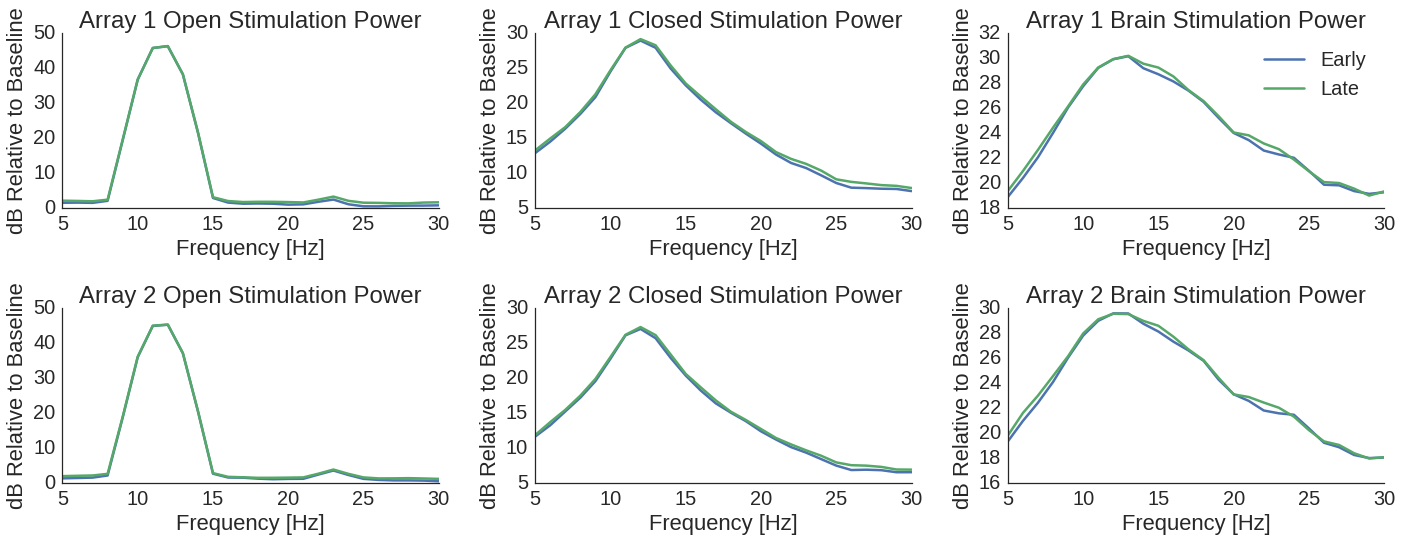

In [66]:
import numpy as np
import os, glob, re
import pylab as plt
import seaborn as sns

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')
        
f, axs = plt.subplots(2, 3, figsize=(20, 8))

for i, condition in enumerate(['Open', 'Closed', 'Brain']):
    
    power = np.load('./power/trial_normalized_tfr/%s_trial_normalized_tfr.npz' % condition)
    
    data = power['power']
    freqs = power['freqs']
    times = power['times']
    chs = power['chs']
    
    # Crop out period of interest
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    early_mask = np.where(np.logical_and(times >= 0, times <= 5))[0]
    late_mask = np.where(np.logical_and(times >= 5, times <= 10))[0]
    
    for j, ix in enumerate([arr1_ix, arr2_ix]):
        
        arr_data = data[ix, :, :].mean(axis=0)
        early_stim_data = arr_data[:, early_mask].mean(axis=-1)
        late_stim_data = arr_data[:, late_mask].mean(axis=-1)
        ax = axs[j, i]
    
        ax.plot(freqs, early_stim_data)
        ax.plot(freqs, late_stim_data)
        
        if j == 0:
            ax.set_title('Array 1 %s Stimulation Power' % condition)
        else:
            ax.set_title('Array 2 %s Stimulation Power' % condition)
        
        if j == 0 and i == 2:
            ax.legend(['Early', 'Late'])
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('dB Relative to Baseline')
            
plt.tight_layout()
sns.despine()
plt.savefig('./plots/manuscript_figures/stimulation_spectra.png')
plt.show()

## [Manuscript Figure] Trial Normalized Pre- and Post-Stimulation Array 1 Band Power

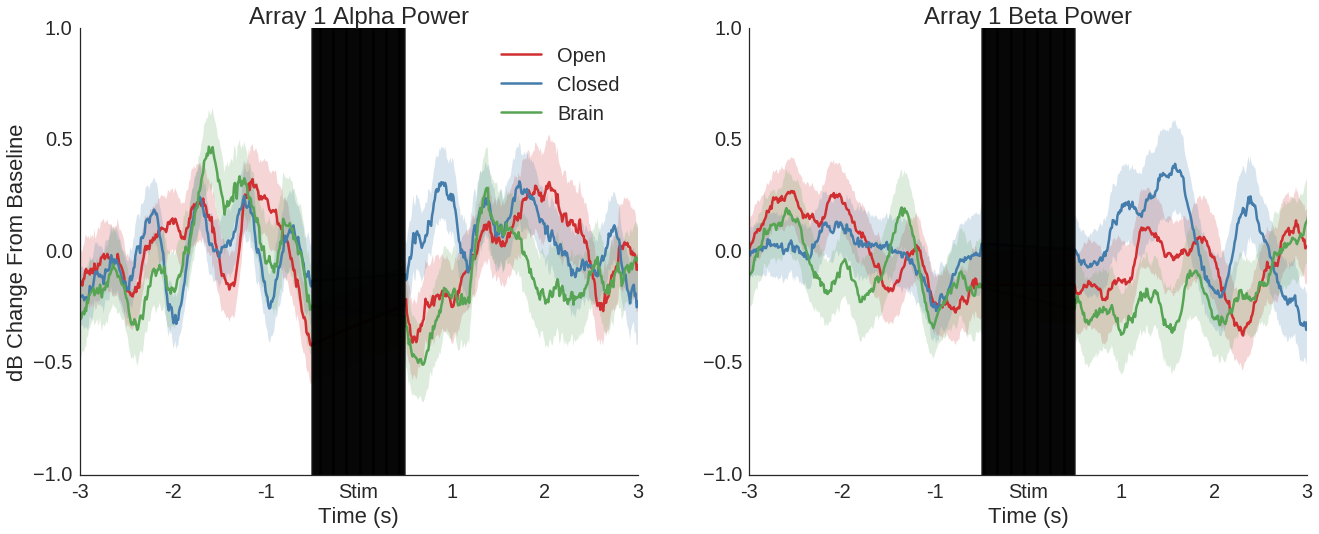

In [67]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]

colors = COLORS[:3]
f, axs = plt.subplots(1, 2, figsize = (22, 8))

for color, c in zip(colors, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    
    # Select out pre and post stimulation
    # Collapse stimulation into 0 and make pre and post stimulation times
    # relative to this 0 (so no longer 10 + for post stimulation)
    times = tmp['times']
    pre_mask = np.logical_and(times >= -5, times <= -.5)
    post_mask = np.logical_and(times >= 10.5, times <= 15)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    times[times >= 10] -= 10
    
    chs = tmp['chs']
    err = np.load("./stats/submitted_for_manuscript/bootstrap/%s_array1_bootstrap_distributions.npz"%(c))
    
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        boot_std = err["%s_stderr"%(band)]
        
        array_data = np.median(data[arr_ix, :].squeeze(), axis=0).squeeze()
        array_data = array_data[time_mask]
        
        axs[i].plot(times, array_data, color=color)
        axs[i].fill_between(times, array_data - boot_std, array_data + boot_std, 
                            facecolor=color, alpha=0.2, edgecolor='none')
        
        axs[i].set_title("Array 1 %s Power" %(band.capitalize()))
        
        axs[i].set_xlabel("Time (s)")
        
        axs[i].set_ylim((-1, 1))
        axs[i].set_xticks([-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
        axs[i].set_xticklabels([-5, -4, -3, -2, -1, 'Stim', 1, 2, 3, 4, 5])
        axs[i].set_xlim((-3, 3))
        
        sns.despine()
        
for i in np.arange(-.5, .5, .01):
    axs[0].axvline(i, color='k', alpha=0.8)
    axs[1].axvline(i, color='k', alpha=0.8)
axs[0].legend(conditions)
axs[0].set_ylabel("dB Change From Baseline")
        
f.savefig("./plots/manuscript_figures/array1_band_power.png")
plt.show()

## [Manuscript Figure] Post Stimulation TOI Band Power

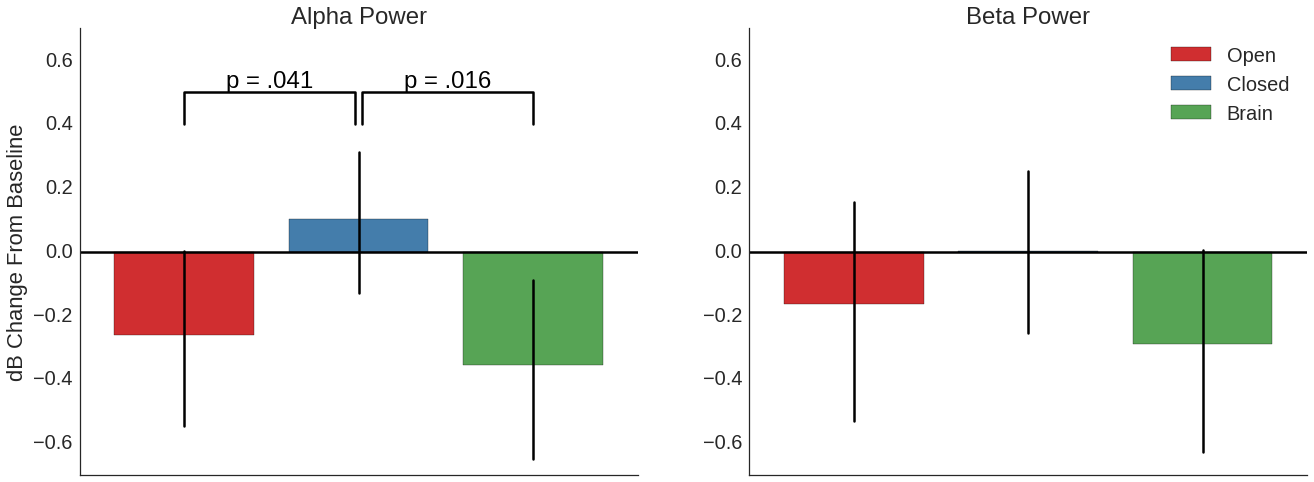

In [68]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
colors = COLORS[:3]
plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]
toi = (10.5, 11.0) # 0.5 to 1 second post stimulation

f, axs = plt.subplots(1, 2, figsize = (22, 8))

# Get bootstrap confidence intervals
bootstrap_info = np.load("./stats/submitted_for_manuscript/bootstrap/toi=(%.2f,%.2f)_%s_bootstrap_p_values.npz" %(toi[0] - 10, toi[1]-10, 'array1'))
cis = bootstrap_info['cis']
k = 0

datas = []

for bar_ix, color, c in zip(range(1, len(conditions) + 1), colors, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    times = tmp['times']
    chs = tmp['chs']
    
    arr_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    toi_ix = np.where(np.logical_and(times > toi[0], times < toi[1]))
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        
        spotlight_data = np.mean(data[spot_ix, :].squeeze(), axis=0).squeeze()
        toi_data = spotlight_data[toi_ix].squeeze().mean()
        ci=cis[k]
        
        axs[i].bar(bar_ix, toi_data, color=color)
        axs[i].plot([bar_ix + .4, bar_ix + .4], ci, color='k', label='_nolegend_')
        
        axs[i].set_title("%s Power" %(band.capitalize()))
        
        axs[i].set_xlim((.8, 4))
        axs[i].set_ylim((-.7, .7))
        axs[i].set_xticks(())
        
        sns.despine()
        
        k += 1
        
axs[1].legend(conditions)
        
# Statistical Annotations
x1, x2 = 1.4, 2.38
y, h, col = .4, .1, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y+h, "p = .041", ha='center', va='bottom', color=col)

x1, x2 = 2.42, 3.4   
y, h, col = .4, .1, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y+h, "p = .016", ha='center', va='bottom', color=col)
        
axs[0].axhline(0, color='k')
axs[1].axhline(0, color='k')
axs[0].set_ylabel("dB Change From Baseline")
        
f.savefig("./plots/manuscript_figures/array1_toi_band_power.png")
plt.show()

## [Manuscript Figure] Trial Normalized Pre- and Post-Stimulation Band Power Array Comparisons

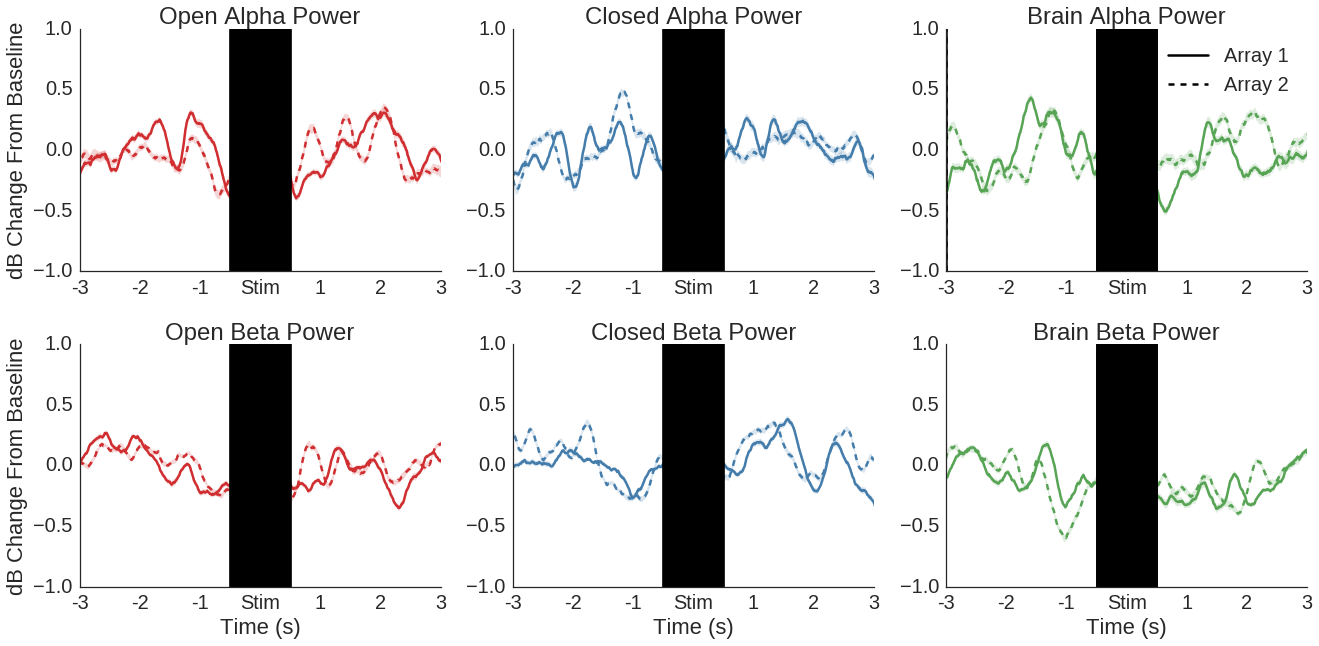

In [69]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os

sns.set(style="white", font_scale=2, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

####################################
# Load Power & Reshape Into Arrays #
####################################

plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]

colors = COLORS[:3]
f, axs = plt.subplots(2, 3, figsize = (22, 10))
plt.subplots_adjust(hspace=.3)

for j, color, c in zip([0, 1, 2], colors, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    
    # Select out pre and post stimulation
    # Collapse stimulation into 0 and make pre and post stimulation times
    # relative to this 0 (so no longer 10 + for post stimulation)
    times = tmp['times']
    pre_mask = np.logical_and(times >= -5, times <= -.5)
    post_mask = np.logical_and(times >= 10.5, times <= 15)
    time_mask = np.where(np.logical_or(pre_mask, post_mask))[0]
    times = times[time_mask]
    times[times >= 10] -= 10
    
    chs = tmp['chs']
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        data = data[:, time_mask]
        arr1_data = np.mean(data[arr1_ix, :].squeeze(), axis=0).squeeze()
        arr2_data = np.mean(data[arr2_ix, :].squeeze(), axis=0).squeeze()
        arr1_std_err = np.std(data[arr1_ix, :].squeeze(), axis=0).squeeze() / np.sqrt(data[arr1_ix, :].squeeze().shape[0])
        arr2_std_err = np.std(data[arr2_ix, :].squeeze(), axis=0).squeeze() / np.sqrt(data[arr2_ix, :].squeeze().shape[0])
        
        axs[i, j].plot(times, arr1_data, color=color, label="_nolegend_")
        axs[i, j].plot(times, arr2_data, color=color, linestyle='--', label="_nolegend_")
        axs[i, j].fill_between(times, arr1_data - arr1_std_err, arr1_data + arr1_std_err, facecolor=color, alpha=0.2, edgecolor='none')
        axs[i, j].fill_between(times, arr2_data - arr2_std_err, arr2_data + arr2_std_err, facecolor=color, alpha=0.2, edgecolor='none')
        
        axs[i, j].set_title("%s %s Power" %(c, band.capitalize()))
        
        axs[i, j].set_xlim((-3, 3))
        axs[i, j].set_xticks([-3, -2, -1, 0, 1, 2, 3])
        axs[i, j].set_xticklabels([-3, -2, -1, 'Stim', 1, 2, 3])
        
        axs[i, j].set_ylim((-1, 1))
        
        sns.despine()
        
        for x in np.arange(-.5, .5, .01):
            axs[i, j].axvline(x, color='k', alpha=0.8, label="_nolegend_")
            axs[i, j].axvline(x, color='k', alpha=0.8, label="_nolegend_")

axs[0, 2].axvline(-3, color='k')
axs[0, 2].axvline(-3, color='k', linestyle='--')
axs[0, 2].legend(["Array 1", "Array 2"])
axs[0, 0].set_ylabel("dB Change From Baseline")
axs[1, 0].set_ylabel("dB Change From Baseline")
axs[1, 0].set_xlabel("Time (s)")
axs[1, 1].set_xlabel("Time (s)")
axs[1, 2].set_xlabel("Time (s)")
        
f.savefig("./plots/manuscript_figures/array_comparison_band_power.png")
plt.show()

## [Manuscript Figure] Post Stimulation TOI Band Power Array Comparisons

Open
alpha
Array 1 Mean: -0.260, Array 2 Mean: -0.028
beta
Array 1 Mean: -0.165, Array 2 Mean: 0.001
Closed
alpha
Array 1 Mean: 0.100, Array 2 Mean: -0.007
beta
Array 1 Mean: 0.005, Array 2 Mean: 0.097
Brain
alpha
Array 1 Mean: -0.351, Array 2 Mean: -0.092
beta
Array 1 Mean: -0.289, Array 2 Mean: -0.169


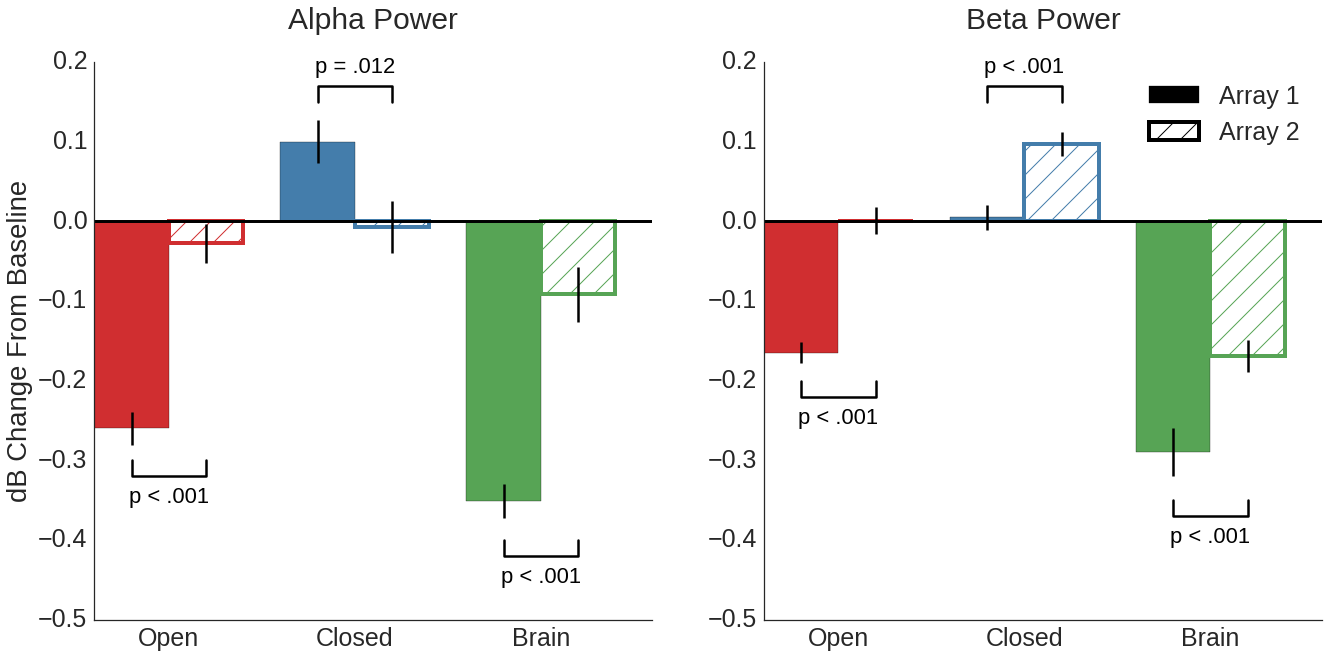

In [70]:
import numpy as np
import pylab as plt
import seaborn as sns
import glob, re, os


sns.set(style="white", font_scale=2.5, rc={"lines.linewidth": 2.5})
COLORS = sns.color_palette("Set1", n_colors=10, desat=.8)
plt.close('all')

####################################
# Load Power & Reshape Into Arrays #
####################################

plt.close('all')

conditions = ["Open", "Closed", "Brain"]
bands = ["alpha", "beta"]
toi = (10.5, 11.0)

colors = COLORS[:3]
f, axs = plt.subplots(1, 2, figsize = (22, 10))
plt.subplots_adjust(hspace=.3)

xticks = [0, 2, 4]
xticklabels = conditions

for bar_ix, c in zip(xticks, conditions):
    
    tmp = np.load("./power/trial_normalized_band_power/%s_trial_normalized_band_power.npz" %(c))
    times = tmp['times']
    chs = tmp['chs']
    print(c)
    
    
    arr1_ix = [ix for ix in np.arange(len(chs)) if 'elec1' in chs[ix] and chs[ix] != 'elec1-84' and chs[ix] != 'elec1-83']
    arr2_ix = [ix for ix in np.arange(len(chs)) if 'elec2' in chs[ix]]
    toi_ix = np.where(np.logical_and(times >= toi[0], times <= toi[1]))
    
    for i, band in enumerate(bands):
        
        data = tmp["%s_power" %(band)]
        arr1_data = data[arr1_ix, :].squeeze()
        arr1_data = arr1_data[:, toi_ix].squeeze().mean(axis=-1).squeeze()
        arr2_data = data[arr2_ix, :].squeeze()
        arr2_data = arr2_data[:, toi_ix].squeeze().mean(axis=-1).squeeze()
        arr1_mean = arr1_data.mean()
        arr2_mean = arr2_data.mean()
        arr1_std_err = arr1_data.std()/np.sqrt(len(arr1_data))
        arr2_std_err = arr2_data.std()/np.sqrt(len(arr2_data))
        print(band)
        print("Array 1 Mean: %.3f, Array 2 Mean: %.3f" %(arr1_mean, arr2_mean))
        
        axs[i].bar(bar_ix, arr1_mean, color=colors[bar_ix//2], yerr=arr1_std_err, ecolor='k')
        axs[i].bar(bar_ix + .8, arr2_mean, facecolor='none', edgecolor=colors[bar_ix//2], linewidth=4,
                   yerr=arr2_std_err, ecolor='k', hatch='/')
        
        
        axs[i].set_xticks([x + .8 for x in xticks])
        axs[i].set_xticklabels(xticklabels)
        axs[i].set_xlim((0, 6))
        axs[i].set_ylim((-.5, .2))
        
        axs[i].set_title("%s Power" %(band.capitalize()), y=1.05)
        axs[i].axhline(0, color='k', label="_nolegend_")
        
        sns.despine()
        
axs[0].set_ylabel("dB Change From Baseline")

axs[1].legend(["Array 1", "Array 2"])
leg = axs[1].get_legend()
leg.legendHandles[0].set_color('black')
leg.legendHandles[1].set_edgecolor('black')

# Statistical Annotations
x1, x2 = .4, 1.2
y, h, col = -.3, .02, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = 2.4, 3.2   
y, h, col = .15, .02, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y+1.5*h, "p = .012", ha='center', va='bottom', color=col, size=22)

x1, x2 = 4.4, 5.2   
y, h, col = -.4, .02, 'k'
axs[0].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[0].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = .4, 1.2
y, h, col = -.2, .02, 'k'
axs[1].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[1].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = 2.4, 3.2   
y, h, col = .15, .02, 'k'
axs[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2.5, c=col)
axs[1].text((x1+x2)*.5, y+1.5*h, "p < .001", ha='center', va='bottom', color=col, size=22)

x1, x2 = 4.4, 5.2   
y, h, col = -.35, .02, 'k'
axs[1].plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=2.5, c=col)
axs[1].text((x1+x2)*.5, y-3*h, "p < .001", ha='center', va='bottom', color=col, size=22)
        
f.savefig("./plots/manuscript_figures/array_comparison_toi_band_power.png")
plt.show()